In [1]:
!pip install yfinance pytrends --quiet

import yfinance as yf
from pytrends.request import TrendReq
import pandas as pd
import time

TARGETS = ['NVDA', 'MSFT', 'GOOGL', 'PLTR']
KEYWORD = 'AI'
START_DATE = '2024-01-01'
END_DATE = '2024-12-31'

try:
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload([KEYWORD], timeframe=f'{START_DATE} {END_DATE}')
    trends_df = pytrends.interest_over_time()
    if 'isPartial' in trends_df.columns:
        trends_df = trends_df.drop(columns=['isPartial'])
    trends_df.columns = ['Search_Volume']
    print(f"구글 검색량 수집 완료 ({len(trends_df)}주)")
except Exception as e:
    print(f"구글 트렌드 에러: {e}")

try:
    stocks_df = yf.download(TARGETS, start=START_DATE, end=END_DATE, progress=False)['Close']
    print(f"주가 데이터 수집 완료 ({len(stocks_df)}일)")
except Exception as e:
    print(f"주가 데이터 에러: {e}")

구글 검색량 수집 완료 (53주)


/tmp/ipython-input-250901107.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stocks_df = yf.download(TARGETS, start=START_DATE, end=END_DATE, progress=False)['Close']


주가 데이터 수집 완료 (251일)


In [2]:
import os

trends_df.to_csv('trend_data_2024.csv')
stocks_df.to_csv('stock_data_2024.csv')
print("CSV 파일 저장 완")

raw_trends = pd.read_csv('trend_data_2024.csv', index_col='date', parse_dates=True)
raw_stocks = pd.read_csv('stock_data_2024.csv', index_col='Date', parse_dates=True)

print(f"   - 검색량 데이터: {raw_trends.shape}")
print(f"   - 주가 데이터: {raw_stocks.shape}")

CSV 파일 저장 완
   - 검색량 데이터: (53, 1)
   - 주가 데이터: (251, 4)


In [3]:
from sklearn.preprocessing import MinMaxScaler


#주가 데이터 리샘플링 (일간 -> 주간)
#구글 트렌드는 '주간' 데이터라서 단위를 맞춰야 병합 가능
# 'W'는 Weekly(일요일 기준) 평균을 의미
weekly_stocks = raw_stocks.resample('W').mean()

# Merge
# 인덱스(날짜)를 기준으로 두 데이터를 합침
df_total = pd.merge(weekly_stocks, raw_trends, left_index=True, right_index=True, how='inner')

# 결측치 처리 - 보간법 고려 중
# 보간법을 사용하여 비어있는 값을 채움
# 보간법이 제일 나을듯 0 넣으면 안됌
df_total = df_total.interpolate(method='linear')

# 데이터 스케일링
# 주가($100~)와 검색량(0~100)의 크기가 다르니 0~1 사이로 변환
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_total),
                         columns=df_total.columns,
                         index=df_total.index)

print("전처리 완료")
print(df_scaled.head())

전처리 완료
               GOOGL      MSFT      NVDA      PLTR  Search_Volume
2024-01-07  0.062227  0.000000  0.000000  0.000000       0.000000
2024-01-14  0.127629  0.128155  0.057897  0.006677       0.162162
2024-01-21  0.161398  0.254383  0.092790  0.004626       0.135135
2024-01-28  0.253324  0.343001  0.128153  0.010378       0.162162
2024-02-04  0.197940  0.394605  0.153612  0.006616       0.081081


In [4]:
# 상관계수 계산
# 1에 가까울수록 양의 상관관계(같이 움직임), 0에 가까울수록 관계없음
correlation_matrix = df_scaled.corr()

# 검색량(Search_Volume)과 각 주가 간의 상관계수만 추출
search_corr = correlation_matrix['Search_Volume'].drop('Search_Volume')

print("AI 검색량과 주가 간의 상관계수:")
print(search_corr.sort_values(ascending=False))

AI 검색량과 주가 간의 상관계수:
PLTR     0.791005
NVDA     0.724028
GOOGL    0.390717
MSFT     0.264587
Name: Search_Volume, dtype: float64


In [5]:
# 1. 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

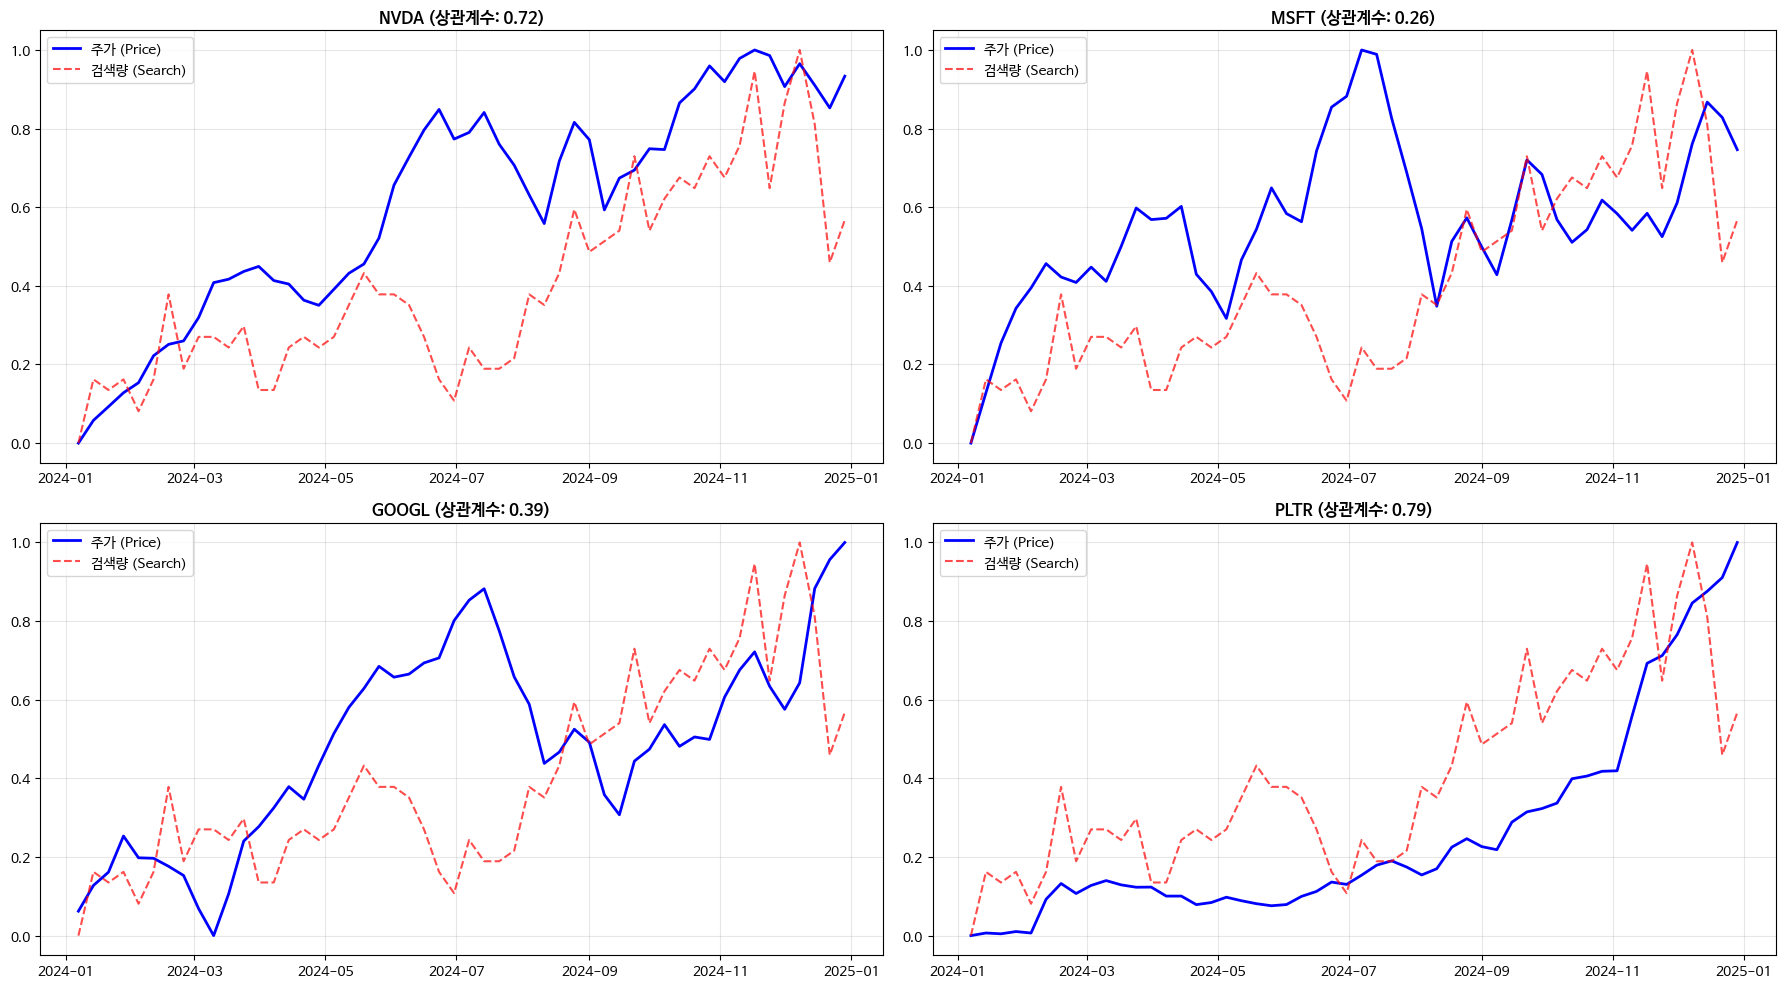

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


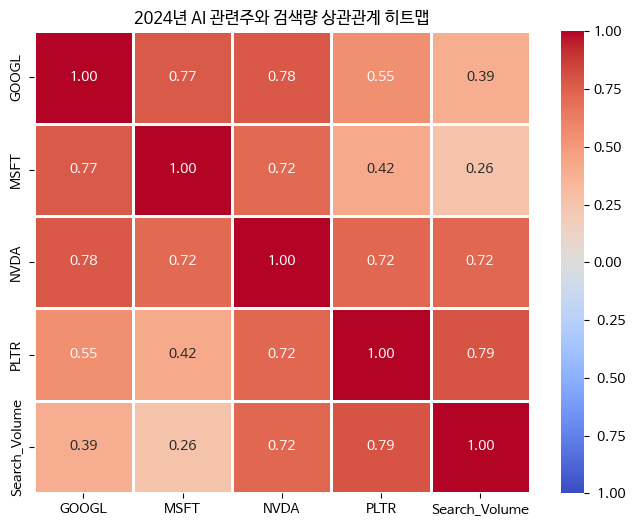

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Colab)
!apt-get -qq -y install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')


# 시계열 추세 비교 그래프 (Subplots) 이걸로
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for i, ticker in enumerate(TARGETS):
    ax = axes[i]

    # 주가 그래프 (파란색)
    ax.plot(df_scaled.index, df_scaled[ticker], label='주가 (Price)', color='blue', linewidth=2)

    # 검색량 그래프 (빨간색 점선)
    ax.plot(df_scaled.index, df_scaled['Search_Volume'], label='검색량 (Search)', color='red', linestyle='--', alpha=0.7)

    # 차트 디자인
    corr_value = search_corr[ticker]
    ax.set_title(f"{ticker} (상관계수: {corr_value:.2f})", fontsize=12, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 상관관계 히트맵
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, vmin=-1, vmax=1)
plt.title("2024년 AI 관련주와 검색량 상관관계 히트맵")
plt.show()

In [7]:
# 정리용으로 만듬 보고서용으로?
print("[결론 및 분석]")
print("-" * 60)

for ticker in TARGETS:
    r = search_corr[ticker]
    print(f"📌 [{ticker}]")

    if r > 0.6:
        explanation = "AI 검색량과 주가가 '매우 강한' 양의 상관관계를 보입니다. 대중의 관심이 주가 상승을 견인하거나 동행하고 있습니다."
    elif r > 0.3:
        explanation = "AI 검색량과 주가가 '어느 정도' 상관관계를 보입니다. 트렌드와 주가가 비슷한 방향성을 가집니다."
    elif r > -0.3:
        explanation = "상관계수가 낮아 뚜렷한 연관성을 찾기 어렵습니다. 해당 기업은 검색량 외에 실적이나 다른 이슈의 영향을 더 많이 받습니다."
    else:
        explanation = "음의 상관관계를 보입니다. 검색량이 늘어날 때 오히려 주가가 하락하거나 그 반대의 경향이 있습니다."

    print(f"   - 상관계수: {r:.4f}")
    print(f"   - 해석: {explanation}\n")
print("-" * 60)

[결론 및 분석]
------------------------------------------------------------
📌 [NVDA]
   - 상관계수: 0.7240
   - 해석: AI 검색량과 주가가 '매우 강한' 양의 상관관계를 보입니다. 대중의 관심이 주가 상승을 견인하거나 동행하고 있습니다.

📌 [MSFT]
   - 상관계수: 0.2646
   - 해석: 상관계수가 낮아 뚜렷한 연관성을 찾기 어렵습니다. 해당 기업은 검색량 외에 실적이나 다른 이슈의 영향을 더 많이 받습니다.

📌 [GOOGL]
   - 상관계수: 0.3907
   - 해석: AI 검색량과 주가가 '어느 정도' 상관관계를 보입니다. 트렌드와 주가가 비슷한 방향성을 가집니다.

📌 [PLTR]
   - 상관계수: 0.7910
   - 해석: AI 검색량과 주가가 '매우 강한' 양의 상관관계를 보입니다. 대중의 관심이 주가 상승을 견인하거나 동행하고 있습니다.

------------------------------------------------------------
